
# Predicting probability of a response message using Bag of Words

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedKFold
import sklearn.ensemble
import statistics
pd.set_option('display.max_rows', 4)

Load the dataset and create a corpus text

In [2]:
messages_df = pd.read_excel("C:/Users/user/UW/keshet - mwach_interaction/SMSdata/mwachNeo/allSMSdatabase/messages_export_2019-03-05.xlsx")
messages_df

,mid,pid,day,timestamp,auto,external,delta_human,delta,delta_last,study_wk,edd_wk,chars,words,topic,related,sent_by,language,translated,original
0,808,15,Tue,2017-12-05 06:36:59.614,signup.two-way.normal.0,Success,NaN,NaN,NaN,0.000000,-9.000000,250,42,NaN,NaN,system,swahili,Welcome to Mobile WACh NEO! Good job coming in...,Karibu kwa Mobile WACh NEO. Kazi nzuri kwa kuj...
1,859,15,Tue,2017-12-05 06:55:45.982,NaN,NaN,18m,1.126367e+03,NaN,0.000000,-9.000000,30,4,validation,1.0,participant,english,NaN,Validation Code Correct: 13514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59504,56843,800,Sun,2018-07-15 17:05:23.401,edd.two-way.normal.14,Failed,NaN,NaN,NaN,8.714286,2.000000,252,41,42 weeks,NaN,system,swahili,"{name}, this is {nurse} from {clinic} Bad swel...","Linet, huyu ni Mercy kutoka Rachuonyo. kufura ..."
59505,67270,800,Mon,2019-02-04 06:31:09.703,NaN,Failed,258d 20h 7m,2.236368e+07,NaN,37.857143,31.142857,354,58,NaN,NaN,nurse,NaN,"{name}, this is {nurse} from {clinic}. Thank y...","Linet, huyu ni Mercy kutoka kwa Rachuonyo. Asa..."


In [3]:
p_data = pd.io.stata.read_stata('C:/Users/user/UW/keshet - mwach_interaction/ParticipantData/mwachNeo/NEO_Enrollment_Interview.dta')
p_data

,today,start,end,site_hand,group1studyid_p2,ptidno,studyid_p2re,group3en_scrid_site,group3en_scrid_id,en_scrid,...,ip_afraid,comment,metainstanceID,group17te_topuphow5,te_topuphow_sp,te_simnum,te_carrier,en_planafterdel,en_whereafterdel,en_whereafterdel_sp
0,2017-12-05,12-5-17 7:58,12-5-17 8:20,Mathare,1,42110001,1,Mathare,17,Nov-17,...,No,ENROLLED SUCCESSFULLY,uuid:49ab8466-159d-4513-9e21-ae9353de78b3,NaN,,NaN,NaN,NaN,NaN,NaN
1,2017-12-05,12-5-17 8:30,12-5-17 8:39,Mathare,2,42110002,2,Rachuonyo,18,46-18,...,No,ENROLLED SUCCESSFULLY,uuid:4e82e0d9-6882-4e18-8028-ae60d1deec6a,NaN,,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,2018-05-15,5-15-18 9:04,5-15-18 9:14,Rachuonyo,799,42460799,799,Rachuonyo,865,46-865,...,No,Enrolled,uuid:6e73839b-6494-478e-9dad-5252216f2e16,NaN,,2.0,Safaricom,Yes,NaN,NaN
797,2018-05-15,5-15-18 9:40,5-15-18 9:49,Rachuonyo,800,42460800,800,Rachuonyo,1054,46-1054,...,No,Enrolled,uuid:65ca53ad-ab4a-44a1-b93e-97ae0156909d,NaN,,2.0,Safaricom,Yes,NaN,NaN


In [4]:
messages_df['system_msg'] = (messages_df['sent_by']=='system')
print("Number of System Messages: ", messages_df['system_msg'].sum())

Number of System Messages:  26021


In [5]:
#We need to know number of responses each system message received. --- we will come back later to remove nurse messages
messages_df['msg_group'] = messages_df.system_msg.cumsum()
messages_df.msg_group.value_counts()

7115     190
24446     39
        ... 
17924      1
2047       1
Name: msg_group, Length: 26021, dtype: int64

In [6]:
#Our responses vector is all those messages with a value count of more than 1
response = (messages_df.msg_group.value_counts() > 1)

In [7]:
#Creating the systemMessage DataFrame to define our features.
systemMesaagesDF = messages_df[messages_df.sent_by == "system"]
systemMesaagesDF = systemMesaagesDF.set_index('msg_group')
systemMesaagesDF['response'] = response
systemMesaagesDF['swahili'] = systemMesaagesDF.language == 'swahili'
systemMesaagesDF['english'] = systemMesaagesDF.language == 'english'
systemMesaagesDF['luo'] = systemMesaagesDF.language == 'luo'
systemMesaagesDF.shape

(26021, 24)

In [8]:
#Let's now filter the columns and convert them to float.
X = systemMesaagesDF.filter(['edd_wk', 'chars', 'words', 'swahili', 'english', 'luo']).astype(np.float32)
y = systemMesaagesDF.response.astype(np.float32)

In [9]:
#Lets create our text corpus
X_text = systemMesaagesDF.original.astype('str')
corpus = X_text.values
corpus

array(['Karibu kwa Mobile WACh NEO. Kazi nzuri kwa kuja kwa ziara yako ya kliniki! Utapokea SMS kila wiki ambayo itakusaidia wakati wa ujauzito na miaka mbili za kwanza za maisha ya mtoto wako.Tafadhali tutumie SMS na uuulize maswali au mashaka yoyote unayo.',
       'Mama Lucas, huyu ni Brenda kutoka Mathare. Wakati mwingine matatizo hutokea wakati unaumwa na wakati wa kujifungua, kama kutokwa na damu au mishtuko ya kifafa , ambayo yanahitaji wafanyakazi wa afya wenye ujuzi, dawa na vifaa vya kutibu. Bila matibabu hayo, mama na mtoto wanaweza kufariki. Kwa hivyo ni salama kabisa kujifungua katika kituo ambacho kinaweza kushughulikia matatizo haya na mengine zaidi. Utafikaje kwenye kituo?',
       'Mama Lucas, huyu ni Brenda kutoka Mathare. kufura vibaya kwa mikono na uso au kuumwa vibaya na kichwa ni ishara ya shida. Ambia familia yako wakupeleke kliniki wakiona haya. Umekuwa na kufura yoyote au kuumwa na kichwa kwa huu ujauzito? Zinaendelea kuzidi?',
       ...,
       'Linet, huyu n

In [35]:
vectorizer = CountVectorizer(stop_words="english")
X_bow = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

['14', '15', '30', '4th', '60', 'aache', 'abby', 'abdomen', 'abel', 'abich', 'abigael', 'able', 'abnormal', 'aboro', 'aboy', 'acheng', 'achiel', 'achieng', 'achieng07', 'active', 'adek', 'adhiambo', 'adjust', 'ado', 'adory', 'aduda', 'advice', 'afternoon', 'afya', 'age', 'agnes', 'agness', 'ahinya', 'aina', 'aisha', 'ajenya', 'ajili', 'akeyo', 'akicheza', 'akifikia', 'akifikisha', 'akijinyoosha', 'akilia', 'akinyi', 'akiwa', 'ako', 'albert', 'alex', 'alice', 'aliciah', 'alikuwa', 'aliviza', 'allowing', 'alopozaliwa', 'alphine', 'aluoch', 'amani', 'ambacho', 'ambako', 'ambao', 'ambayo', 'ambeza', 'ambia', 'amealala', 'ameanza', 'amefikisha', 'amelala', 'amepokea', 'amina', 'aminga', 'amora', 'ana', 'anaacha', 'anaenda', 'anaendeleaje', 'anafikia', 'anahitaji', 'anajinyoosha', 'anakuwa', 'analala', 'analia', 'ananyonya', 'anaonekana', 'anapaswa', 'anapozaliwa', 'anasumbua', 'anatoa', 'anaumwa', 'anaweza', 'anayetumia', 'ane', 'ang', 'angalia', 'angel', 'angela', 'angie', 'angwen', 'anita

In [36]:
sum_words = X_bow.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [37]:
words_freq

[('baby', 19218),
 ('na', 18778),
 ('brenda', 17262),
 ('mathare', 16288),
 ('kwa', 15960),
 ('ni', 15836),
 ('ya', 15814),
 ('mtoto', 14846),
 ('kutoka', 12266),
 ('huyu', 11302),
 ('mercy', 10142),
 ('rachuonyo', 9547),
 ('mama', 9147),
 ('wako', 7246),
 ('au', 7186),
 ('wakati', 6341),
 ('mara', 5453),
 ('wa', 5215),
 ('planning', 3904),
 ('je', 3890),
 ('yoyote', 3690),
 ('ikiwa', 3671),
 ('family', 3603),
 ('una', 3521),
 ('yako', 3140),
 ('know', 3059),
 ('problems', 2991),
 ('uzazi', 2976),
 ('kuwa', 2765),
 ('tafadhali', 2620),
 ('hii', 2583),
 ('help', 2493),
 ('sms', 2448),
 ('wiki', 2435),
 ('facility', 2323),
 ('having', 2310),
 ('matatizo', 2272),
 ('come', 2244),
 ('nyathi', 2223),
 ('mawuok', 2203),
 ('en', 2203),
 ('bende', 2165),
 ('let', 2162),
 ('bleeding', 2161),
 ('kama', 2157),
 ('clinic', 2117),
 ('kujifungua', 2098),
 ('sana', 2098),
 ('ka', 2096),
 ('time', 2089),
 ('deliver', 2084),
 ('wach', 2024),
 ('ishara', 2011),
 ('kichwa', 2001),
 ('damu', 1990),
 ('vis

In [38]:
print(X_bow.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [39]:
# Prepare training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.10, train_size=0.90, random_state=55)


In [16]:
X_train.shape

(23418, 2283)

In [17]:
X_test.shape

(2603, 2283)

In [18]:
y_train.shape

(23418,)

In [19]:
y_test.shape

(2603,)

In [20]:
X_train[0]

<1x2283 sparse matrix of type '<class 'numpy.int64'>'
	with 35 stored elements in Compressed Sparse Row format>

In [13]:
vectorizer.inverse_transform(X_train[0])

[array(['mama', 'brenda', 'mathare', 'to', 'you', 'and', 'the', 'of',
        'any', 'or', 'this', 'is', 'from', 'sometimes', 'problems', 'can',
        'these', 'are', 'feel', 'having', 'new', 'many', 'all', 'time',
        'sleeping', 'crying', 'happens', 'women', 'mothers', 'sad',
        'anxious', 'worried', 'cause', 'difficulty', 'terry'], dtype='<U27')]

# 1. Fitting the model Using BoW as the feature input only

In [40]:
#We now fit the model
logreg = sklearn.linear_model.LogisticRegression(solver='lbfgs', max_iter=570)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=570, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [41]:
print(logreg.coef_)

[[-0.22238013 -0.09007933  0.01432621 ...  0.20382396  0.84594713
  -0.20272417]]


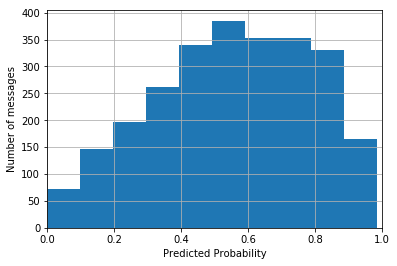

In [42]:
prediction = logreg.predict(X_test)
pr = logreg.predict_proba(X_test)
plt.hist(pr[:,0])
plt.xlabel('Predicted Probability')
plt.ylabel('Number of messages')
plt.axis(xmin=0, xmax=1)
plt.grid();

In [43]:
#Let's testing out the predictions
#1. accuracy_score
accuracy_score(y_test, prediction)
#logreg.score(X_test, y_test)

0.6941990011525163

In [44]:
#Let's also do roc-auc-score
roc_auc_score(y_test, pr[:,1])

0.7664876713377746

In [45]:
#Let do BoW on GradientBoosting
gb_model = sklearn.ensemble.GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

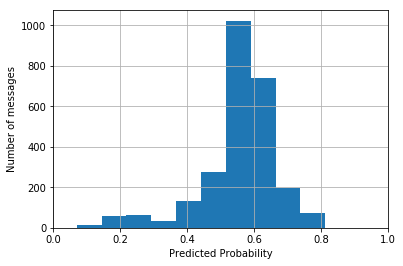

In [46]:
prediction = gb_model.predict(X_test)
pr = gb_model.predict_proba(X_test)
plt.hist(pr[:,0])
plt.xlabel('Predicted Probability')
plt.ylabel('Number of messages')
plt.axis(xmin=0, xmax=1)
plt.grid();

In [47]:
accuracy_score(y_test, prediction)

0.6477141759508259

In [48]:
#Let's also do roc-auc-score
roc_auc_score(y_test, pr[:,1])

0.6978571411478673

In [49]:
#K-Fold for BoW
rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2652124)
accuracy = []
roc = []
model = sklearn.ensemble.GradientBoostingClassifier()
for train_index, test_index in rkf.split(X_bow, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pr = model.predict_proba(X_test)
    accuracy.append(accuracy_score(y_test, pred))  #converting the preditions to 100%
    roc.append(roc_auc_score(y_test, pr[:,1])*100)
    


0.6162638952335197

In [50]:
statistics.mean(accuracy)

0.6162638952335197

In [51]:
statistics.mean(roc)

64.16365425594729

ValueError: Length of values does not match length of index

# 2. Using EDD and language to predict probability of text response and measuring its performance

In [49]:
X = systemMesaagesDF.filter(['edd_wk', 'swahili', 'english', 'luo']).astype(float)

In [50]:
#Split dataset into training and testing sets.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=55)

In [51]:
#Fitting the model
clf = sklearn.linear_model.LogisticRegression(solver='lbfgs', max_iter=550)
clf.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=550, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

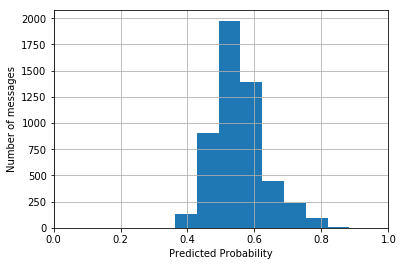

In [52]:
pr = clf.predict_proba(x_test)
plt.hist(pr[:,0])
plt.xlabel('Predicted Probability')
plt.ylabel('Number of messages')
plt.axis(xmin=0, xmax=1)
plt.grid();

In [53]:
#lets measure the performance of this model
#accuracy_score
predict = clf.predict(x_test)
accuracy_score(y_test, predict)

0.5771373679154659

In [54]:
#score
clf.score(x_test, y_test)

0.5771373679154659

In [55]:
#Let's also do roc-auc-score
roc_auc_score(y_test, pr[:,1])

0.5794727937737791

In [56]:
#K-Fold for BoW
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2652124)
accuracy = []
roc_auc = []
model = sklearn.linear_model.LogisticRegression(solver='lbfgs', max_iter=550)
for train_index, test_index in rkf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    accuracy.append(accuracy_score(y_test, pred))  #converting the preditions to 100%
    #roc_auc.append(roc_auc_score(y_test, pred)*100)
    
statistics.mean(accuracy)

0.5767419001252915

# 3. Using BoW, EDD, and Languages as all features to predict probability of response.

In [57]:
import scipy as sp
all_features = sp.sparse.hstack((vectorizer.fit_transform(corpus),
                      systemMesaagesDF[['edd_wk', 'chars', 'words', 'swahili', 'english', 'luo']].values.astype(np.float32)), format='csr')


In [58]:
#all_features.toarray()
all_features.shape

(26021, 2289)

In [67]:
#show all columns
all_features_columns = systemMesaagesDF[['edd_wk', 'chars', 'words', 'swahili', 'english', 'luo']].columns.tolist() + vectorizer.get_feature_names()
all_features_columns

['edd_wk',
 'chars',
 'words',
 'swahili',
 'english',
 'luo',
 '14',
 '15',
 '30',
 '4th',
 '60',
 'aache',
 'abby',
 'abdomen',
 'abel',
 'abich',
 'abigael',
 'able',
 'abnormal',
 'aboro',
 'about',
 'aboy',
 'acheng',
 'achiel',
 'achieng',
 'achieng07',
 'across',
 'active',
 'adek',
 'adhiambo',
 'adjust',
 'ado',
 'adory',
 'aduda',
 'advice',
 'after',
 'afternoon',
 'afya',
 'again',
 'against',
 'age',
 'agnes',
 'agness',
 'ahinya',
 'aina',
 'aisha',
 'ajenya',
 'ajili',
 'akeyo',
 'akicheza',
 'akifikia',
 'akifikisha',
 'akijinyoosha',
 'akilia',
 'akinyi',
 'akiwa',
 'ako',
 'albert',
 'alex',
 'alice',
 'aliciah',
 'alikuwa',
 'aliviza',
 'all',
 'allowing',
 'alopozaliwa',
 'alphine',
 'also',
 'aluoch',
 'always',
 'amani',
 'ambacho',
 'ambako',
 'ambao',
 'ambayo',
 'ambeza',
 'ambia',
 'amealala',
 'ameanza',
 'amefikisha',
 'amelala',
 'amepokea',
 'amina',
 'aminga',
 'amora',
 'an',
 'ana',
 'anaacha',
 'anaenda',
 'anaendeleaje',
 'anafikia',
 'anahitaji',
 'a

In [68]:
xtrain, xtest, ytrain, ytest = train_test_split(all_features, y, test_size=0.20, random_state=60)

In [69]:
#Fitting the model
#Note: Its taking long to converge, perhaps we should consider scaling some features like chars, words
model = sklearn.linear_model.LogisticRegression(solver='lbfgs', max_iter=5000)
model.fit(xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

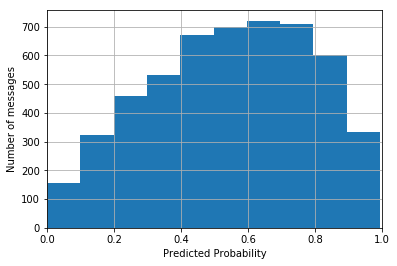

In [70]:
#Lets visualize some test predictions.
pred = model.predict_proba(xtest)
plt.hist(pred[:,0])
plt.xlabel('Predicted Probability')
plt.ylabel('Number of messages')
plt.axis(xmin=0, xmax=1)
plt.grid();

In [71]:
#lets measure the performance of this model
#accuracy_score
predicted = model.predict(xtest)
accuracy_score(ytest, predicted)

0.6922190201729107

In [72]:
roc_auc_score(ytest, predicted)

0.6855376706360385

In [73]:
#Let's also do roc-auc-score
roc_auc_score(ytest, pred[:,0])

0.23496594441287832

In [74]:
#Let's also do roc-auc-score
roc_auc_score(ytest, pred[:,1])

0.7650340555871217

In [75]:
#K-Fold for BoW
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2652124)
accuracy = []
roc_auc = []
model = sklearn.linear_model.LogisticRegression(solver='lbfgs', max_iter=5000)
for train_index, test_index in rkf.split(all_features, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    accuracy.append(accuracy_score(y_test, pred))  #converting the preditions to 100%
    #roc_auc.append(roc_auc_score(y_test, pred)*100)
    
statistics.mean(accuracy)


0.5767419001252915